# Stochastic Modelling in fmdtools

This notebook covers the basics of stochastic modelling in fmdtools. Stochastic models are models which run *non-determinsitically*, meaning that simulating the model at the same inputs results in different outputs because of randomness or uncertainty in the model behavior. Thus, to determine the *distribution of outcomes* which may result from a simulation, a stochastic model must be run a number of times. This notebook will cover:
- How to construct a stochastic model by adding *stochastic states* to function blocks and incorporating them in function behavior
- How to simulate single scenarios and distributions of scenarios in `propagate` methods
- How to visualize and analyze the results of stochastic model simulations

In [1]:
from fmdtools.sim.approach import SampleApproach, NominalApproach
from fmdtools.define.block import FxnBlock, Block
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
from fmdtools.analyze.graph import ModelGraph

import inspect # we will be using inspect to look at 

This notebook uses Pump model in `pump_stochastic.py`, which is an adaptation of the original `ex_pump.py` model with stochastic states added. 

In [2]:
from pump_stochastic import Pump

Below is the structure, with the same functions/flows as before.

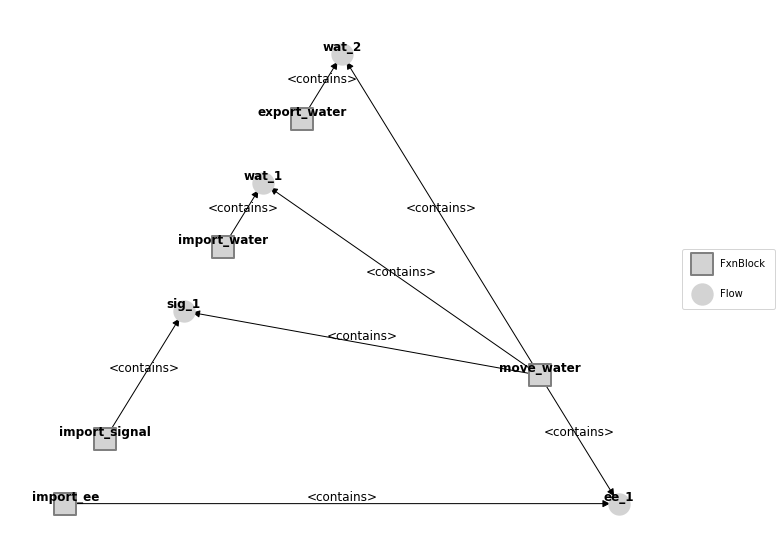

In [3]:
mg = ModelGraph(Pump())
fig, ax = mg.draw()

## Model Setup

This model has been augmented stochastic states and behaviors to enable stochastic simulation using the `Rand` class. 

- See rand documentation: https://nasa.github.io/fmdtools/docs/fmdtools.define.html#fmdtools.define.rand.Rand

This is what a Rand object looks like:

In [4]:
from fmdtools.define.rand import Rand
r = Rand()
r

Rand(rng=Generator(PCG64) at 0x2094B05AAC0, probs=[], probdens=1.0, seed=42, run_stochastic=False)

Below, `assoc_rand_states` is used in the ImportEE function to add two random states:
- `effstate`, the quality of the input voltage (i.e. large fluctuations from a step change in power)
- `grid_noise`, which is meant to be fluctuations in voltage from the power source (i.e., more ordinary noise)

This is then reflected in the behavior, which is defined in the `Rand.set_rand` method. 

In [5]:
help(Rand.set_rand)

Help on function set_rand in module fmdtools.define.rand:

set_rand(self, statename, methodname, *args)
    Update the given random state with a given method and arguments
    (if in run_stochastic mode)
    
    Parameters
    ----------
    statename : str
        name of the random state defined in assoc_rand_state(s)
    methodname :
        str name of the numpy method to call in the rng
    *args : args
        arguments for the numpy method



In this method, 

- `statename` is the name of the random state, while 
- `methodname` corresponds to the name of a random distribution to update the state from. These distributions are pulled from a numpy random number generator (see [numpy documentation](https://numpy.org/doc/stable/reference/random/generator.html#distributions)) and include most one might need including normal, beta, uniform, etc. 

- `*args` refers to the corresponding arguments to call the given method with, which should be pulled from the corresponding documentation. Below, we have points where this is called.

Belo we show how this is used in the model:

In [6]:
from pump_stochastic import ImportEERand, ImportEERandState, ImportEE

In [7]:
print(inspect.getsource(ImportEERand))
print(inspect.getsource(ImportEERandState))

class ImportEERand(Rand):
    s = ImportEERandState()

class ImportEERandState(State):
    effstate: float = 1.0
    grid_noise: float = 1.0



In this setup, the `effstate` and `grid_noise` states are to be set by the rng in `ImportEERand`. Below shows how this is embodied in behavior:

In [8]:
print(inspect.getsource(ImportEE.behavior))

    def behavior(self, time):
        if self.m.has_fault('no_v'):
            self.r.s.effstate = 0.0  # an open circuit means no voltage is exported
        elif self.m.has_fault('inf_v'):
            self.r.s.effstate = 100.0  # a voltage spike means voltage is much higher
        else:
            if time > self.t.time:
                self.r.set_rand('effstate', 'triangular', 0.9, 1, 1.1)
        if time > self.t.time:
            self.r.set_rand('grid_noise', 'normal', 1, 0.05*(2+np.sin(np.pi/2*time)))
        self.ee_out.s.voltage = self.r.s.grid_noise*self.r.s.effstate * 500



As shown, `set_rand` is used:

- First, to pull `effstate` from a triangular distribution with minimum 0.9, mode 1.0, and max 1.1
 - Parameters are provided here: https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.triangular.html#numpy.random.Generator.triangular
- Second, to pull `grid_noise` from a normal distribution centered on 1 with a standard deviation that varies over time according to a sine wave.
 - Parameters are provided here: https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal

#### Move Water  Example
The Move Water function has a similar setup, except the stochasticity is auto-updated at each timestep. This is done by providing an `eff_update` class varaible to the `RandState`.

In [9]:
from pump_stochastic import MoveWat, MoveWatRandState, MoveWatRand

In [10]:
print(inspect.getsource(MoveWatRandState))

class MoveWatRandState(State):
    eff: float = 1.0
    eff_update = ('normal', (1.0, 0.2))



In this case, the normal distribution will be drawn from with mean 1.0 and standard deviation 0.2.

The advantage of this is that simple stochastic behaviors do not need to be defined in the behavior method, however, it is less flexible than the previous approach, since one is limited to always drawing from the same distribution at each time-step. The corresponding behavior method (below) thus has no `set_rand` call, since the state `eff` is automaticall updated outside the behavior definition.

In [11]:
print(inspect.getsource(MoveWat.behavior))

    def behavior(self, time):
        self.s.eff = self.r.s.eff
        super().behavior(time)
        if time > self.t.time:
            self.s.inc(total_flow=self.wat_out.s.flowrate)



#### Model Considerations

To get a distribution of stochastic behavior, the simulation must be run over a number of different random seeds. This `seed` parameter ensures that each simulation in the same random thread will produce the same results, and that results can be replicated from stochastic simulation by running the model with the same seed.

By default, the seed for the `Rand` in each of the functions is set to match the Model `Rand`, meaning that passing a sead at the `Model` level sets it in all the containing functions also. This can be set by passing an `r` parameter to the Model.

In [12]:
mdl1 = Pump(r={'seed':23})
mdl1.fxns['move_water'].r

MoveWatRand(rng=Generator(PCG64) at 0x2094B09DC80, probs=[], probdens=1.0, seed=23, run_stochastic=False)

In [13]:
mdl2 = Pump(r={'seed':10})
mdl2.fxns['move_water'].r

MoveWatRand(rng=Generator(PCG64) at 0x2094B45CBA0, probs=[], probdens=1.0, seed=10, run_stochastic=False)

## Simulation and Analysis

With this model set up, we can now simulate it using the methods in `propagate`.

### Single-Scenario Simulation

First, let's simulate it in the nominal scenario:

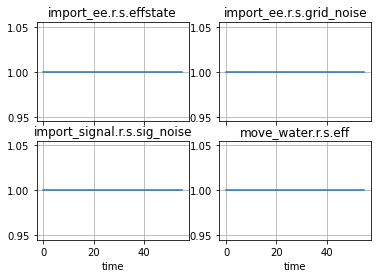

In [14]:
mdl = Pump()
endclass, mdlhist = propagate.nominal(mdl)
fig, axs = an.plot.hist(mdlhist, 'import_ee.r.s.effstate', 
                        'import_ee.r.s.grid_noise', 
                        'import_signal.r.s.sig_noise',
                        'move_water.r.s.eff')

As shown, even with all of these random states, it doesn't appear that the behavior actually changes stochastically over time. This is because, by default, the model is set to run *deterministically*, meaning the stochastic states take their default values. To run stochastically, we use the option `run_stochastic=True`.

In [15]:
mdl = Pump()
endclass, mdlhist = propagate.nominal(mdl, run_stochastic=True)

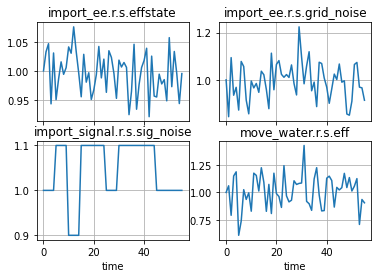

In [16]:
fig, axs = an.plot.hist(mdlhist, 'import_ee.r.s.effstate', 
                        'import_ee.r.s.grid_noise', 
                        'import_signal.r.s.sig_noise',
                        'move_water.r.s.eff')

As shown, this is more what we would expect from a random . Note that this simulation comes from the default model seed, and will this will always be the same. To get a different seed, we can pass new modelparams as an argument to `propagate.nominal`

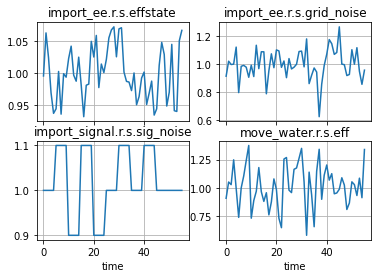

In [17]:
mdl = Pump()
endclass, mdlhist = propagate.nominal(mdl, run_stochastic=True, 
                                      mdl_kwargs=dict(r={'seed':110}))
fig, axs = an.plot.hist(mdlhist, 'import_ee.r.s.effstate', 
                        'import_ee.r.s.grid_noise', 
                        'import_signal.r.s.sig_noise',
                        'move_water.r.s.eff')

We can further simulate faults as we would before. 

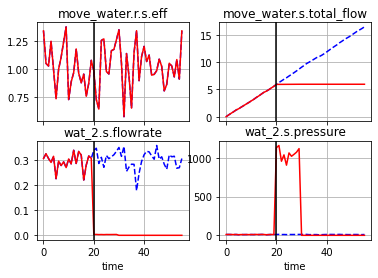

In [18]:
mdl = Pump()
endclass, mdlhist = propagate.one_fault(mdl, 'export_water','block', time=20, 
                                       run_stochastic=True, mdl_kwargs=dict(r={'seed':110}))
fig = an.plot.hist(mdlhist, 'move_water.r.s.eff', 
                       'move_water.s.total_flow',
                       'wat_2.s.flowrate',
                       'wat_2.s.pressure',
                       time_slice=[20], legend_loc=False)

As shown, the stochastic states still simulated over time after the fault. 

One thing to watch in stochastic models is that **off-nominal behavior may be more difficult to track**, since stochastic behavior may vary without necessarily being adverse behavior. This can be a problem because many of the visualizations (e.g., in `graph`) are based on finding *differences* between faulty and nominal models to visualize degradation, these methods may be less useful/reliable.

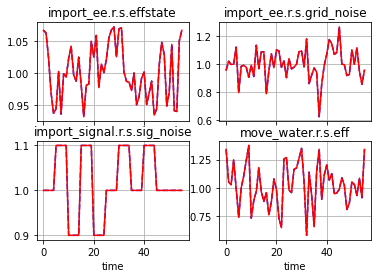

In [19]:
fig = an.plot.hist(mdlhist, 'import_ee.r.s.effstate', 
                        'import_ee.r.s.grid_noise', 
                        'import_signal.r.s.sig_noise',
                        'move_water.r.s.eff', legend_loc=False)

In the blockage scenario, there is no effect on the underlying stochastic states, since nothing was set up for this in the behavior. In the `no_sig` fault, on the other hand, we defined the signal noise to go to zero, as shown:

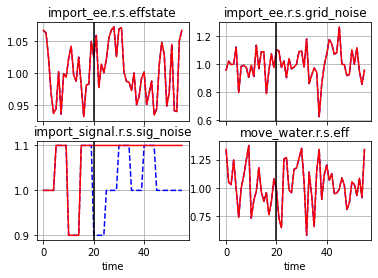

In [20]:
mdl = Pump()
endclass, mdlhist = propagate.one_fault(mdl, 'import_signal', 'no_sig', time=20, 
                                        run_stochastic=True, mdl_kwargs=dict(r={'seed':110}))
fig = an.plot.hist(mdlhist, 'import_ee.r.s.effstate', 
                        'import_ee.r.s.grid_noise', 
                        'import_signal.r.s.sig_noise',
                        'move_water.r.s.eff', 
                   legend_loc=False,
                   time_slice=20)

### Multi-Scenario Simulation

Because stochastic models are non-deterministic, we are often interested not in the results of a single thread, but of the distribution of outcomes that might occur. To perform this kind of assessment, we can use a `NominalApproach` to instantiate the model with a number of different seeds.

In [21]:
help(NominalApproach.add_seed_replicates)

Help on function add_seed_replicates in module fmdtools.sim.approach:

add_seed_replicates(self, rangeid, seeds)
    Generates an approach with different seeds to use for the model's internal stochastic behaviors
    
    Parameters
    ----------
    rangeid : str
        Name for the set of replicates
    seeds : int/list
        Number of seeds (if an int) or a list of seeds to use.



A `seeds` option can also be used in several other NominalApproach methods to simultaneously change the input parameters and seeds of the model. Below, we create an approach to simulate the model 100 times.

In [22]:
app = NominalApproach()
app.add_seed_replicates('test_seeds', 100)

In [23]:
endclasses, mdlhists=propagate.nominal_approach(mdl,app, run_stochastic=True)

SCENARIOS COMPLETE:   0%|          | 0/100 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   4%|▍         | 4/100 [00:00<00:02, 39.11it/s]

SCENARIOS COMPLETE:   9%|▉         | 9/100 [00:00<00:02, 37.30it/s]

SCENARIOS COMPLETE:  13%|█▎        | 13/100 [00:00<00:02, 38.35it/s]

SCENARIOS COMPLETE:  17%|█▋        | 17/100 [00:00<00:02, 38.92it/s]

SCENARIOS COMPLETE:  21%|██        | 21/100 [00:00<00:02, 39.25it/s]

SCENARIOS COMPLETE:  25%|██▌       | 25/100 [00:00<00:02, 37.48it/s]

SCENARIOS COMPLETE:  29%|██▉       | 29/100 [00:00<00:01, 37.26it/s]

SCENARIOS COMPLETE:  33%|███▎      | 33/100 [00:00<00:01, 37.88it/s]

SCENARIOS COMPLETE:  38%|███▊      | 38/100 [00:00<00:01, 39.02it/s]

SCENARIOS COMPLETE:  42%|████▏     | 42/100 [00:01<00:01, 38.27it/s]

SCENARIOS COMPLETE:  46%|████▌     | 46/100 [00:01<00:01, 37.96it/s]

SCENARIOS COMPLETE:  50%|█████     | 50/100 [00:01<00:01, 37.94it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 54/100 [00:01<00:01, 38.06it/s]

SCENARIOS COMPLETE:  59%|█████▉    | 59/100 [00:01<00:01, 39.42it/s]

SCENARIOS COMPLETE:  63%|██████▎   | 63/100 [00:01<00:00, 38.47it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 67/100 [00:01<00:00, 38.87it/s]

SCENARIOS COMPLETE:  71%|███████   | 71/100 [00:01<00:00, 39.19it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 75/100 [00:01<00:00, 39.39it/s]

SCENARIOS COMPLETE:  79%|███████▉  | 79/100 [00:02<00:00, 39.54it/s]

SCENARIOS COMPLETE:  83%|████████▎ | 83/100 [00:02<00:00, 37.90it/s]

SCENARIOS COMPLETE:  87%|████████▋ | 87/100 [00:02<00:00, 38.50it/s]

SCENARIOS COMPLETE:  91%|█████████ | 91/100 [00:02<00:00, 38.91it/s]

SCENARIOS COMPLETE:  95%|█████████▌| 95/100 [00:02<00:00, 39.20it/s]

SCENARIOS COMPLETE:  99%|█████████▉| 99/100 [00:02<00:00, 37.69it/s]

SCENARIOS COMPLETE: 100%|██████████| 100/100 [00:02<00:00, 38.34it/s]

To evaluate this behavior over time, we can then use `an.plot.hist`, to plot the *distribution* of behaviors over time.  `an.plot.hist` has a number of different options for visualization of distributions. For example, below we plot model states as individual lines:

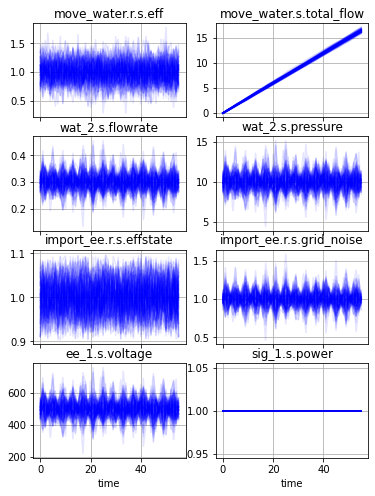

In [24]:
fig = an.plot.hist(mdlhists, 'move_water.r.s.eff', 'move_water.s.total_flow',
                   'wat_2.s.flowrate', 'wat_2.s.pressure',
                   'import_ee.r.s.effstate', 'import_ee.r.s.grid_noise',
                   'ee_1.s.voltage', 'sig_1.s.power',
                   color='blue', comp_groups={}, alpha=0.1, legend_loc=False)

Or as percentiles:

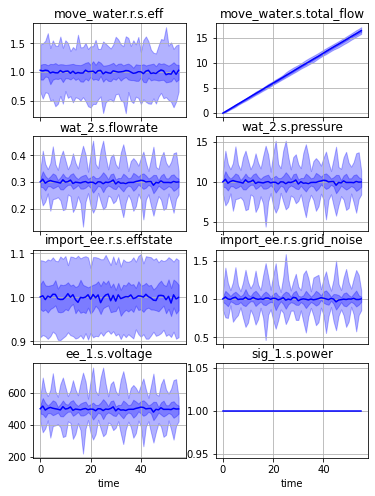

In [25]:
fig = an.plot.hist(mdlhists, 'move_water.r.s.eff', 'move_water.s.total_flow',
                   'wat_2.s.flowrate', 'wat_2.s.pressure',
                   'import_ee.r.s.effstate', 'import_ee.r.s.grid_noise',
                   'ee_1.s.voltage', 'sig_1.s.power',
                   color='blue', comp_groups={}, aggregation='percentile') 

Or as a mean with confidence interval:

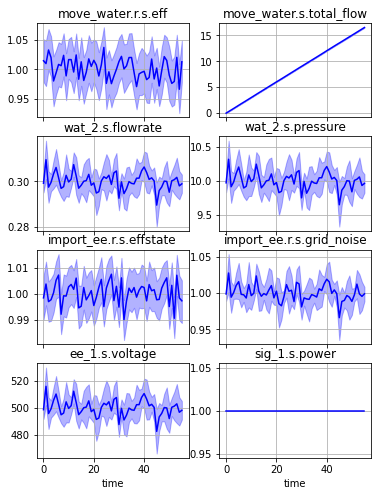

In [26]:
fig = an.plot.hist(mdlhists, 'move_water.r.s.eff', 'move_water.s.total_flow',
                   'wat_2.s.flowrate', 'wat_2.s.pressure',
                   'import_ee.r.s.effstate', 'import_ee.r.s.grid_noise',
                   'ee_1.s.voltage', 'sig_1.s.power',
                   color='blue', comp_groups={}, aggregation='mean_ci')

### Nested Fault Simulation

We can also compare stochastic output over a set of scenarios using `plot.hist` with the `comp_groups` parameter, which places the scenarios in different groups.

In [27]:
def paramfunc(delay=1):
    return {'delay':delay}

This can be done by first creating an approach with two parameters we wish to compare. The pump still has one real parameter--the fault delay.

In [28]:
app_comp = NominalApproach()
app_comp.add_param_replicates(paramfunc, 'delay_1', 100, delay=1)
app_comp.add_param_replicates(paramfunc, 'delay_10', 100, delay=10)

Since this delay only shows up in blockage fault modes, to compare the behaviors, we will first simulate it in a nested approach with only the blockage fault added.

In [29]:
import multiprocessing as mp

In [30]:
pool=mp.Pool(4)

In [31]:
endclasses, mdlhists, apps=propagate.nested_approach(mdl,app_comp, run_stochastic=True, faults=[('export_water','block')])

NESTED SCENARIOS COMPLETE:   0%|          | 0/200 [00:00<?, ?it/s]

NESTED SCENARIOS COMPLETE:   0%|          | 1/200 [00:00<00:29,  6.71it/s]

NESTED SCENARIOS COMPLETE:   1%|          | 2/200 [00:00<00:26,  7.45it/s]

NESTED SCENARIOS COMPLETE:   2%|▏         | 3/200 [00:00<00:26,  7.35it/s]

NESTED SCENARIOS COMPLETE:   2%|▏         | 4/200 [00:00<00:26,  7.45it/s]

NESTED SCENARIOS COMPLETE:   2%|▎         | 5/200 [00:00<00:25,  7.51it/s]

NESTED SCENARIOS COMPLETE:   3%|▎         | 6/200 [00:00<00:26,  7.41it/s]

NESTED SCENARIOS COMPLETE:   4%|▎         | 7/200 [00:00<00:25,  7.47it/s]

NESTED SCENARIOS COMPLETE:   4%|▍         | 8/200 [00:01<00:25,  7.51it/s]

NESTED SCENARIOS COMPLETE:   4%|▍         | 9/200 [00:01<00:25,  7.46it/s]

NESTED SCENARIOS COMPLETE:   5%|▌         | 10/200 [00:01<00:25,  7.47it/s]

NESTED SCENARIOS COMPLETE:   6%|▌         | 11/200 [00:01<00:24,  7.79it/s]

NESTED SCENARIOS COMPLETE:   6%|▌         | 12/200 [00:01<00:24,  7.73it/s]

NESTED SCENARIOS COMPLETE:   6%|▋         | 13/200 [00:01<00:24,  7.58it/s]

NESTED SCENARIOS COMPLETE:   7%|▋         | 14/200 [00:01<00:24,  7.59it/s]

NESTED SCENARIOS COMPLETE:   8%|▊         | 15/200 [00:01<00:24,  7.56it/s]

NESTED SCENARIOS COMPLETE:   8%|▊         | 16/200 [00:02<00:24,  7.50it/s]

NESTED SCENARIOS COMPLETE:   8%|▊         | 17/200 [00:02<00:24,  7.37it/s]

NESTED SCENARIOS COMPLETE:   9%|▉         | 18/200 [00:02<00:24,  7.44it/s]

NESTED SCENARIOS COMPLETE:  10%|▉         | 19/200 [00:02<00:24,  7.54it/s]

NESTED SCENARIOS COMPLETE:  10%|█         | 20/200 [00:02<00:23,  7.68it/s]

NESTED SCENARIOS COMPLETE:  10%|█         | 21/200 [00:02<00:23,  7.54it/s]

NESTED SCENARIOS COMPLETE:  11%|█         | 22/200 [00:02<00:23,  7.45it/s]

NESTED SCENARIOS COMPLETE:  12%|█▏        | 23/200 [00:03<00:29,  6.05it/s]

NESTED SCENARIOS COMPLETE:  12%|█▏        | 24/200 [00:03<00:27,  6.44it/s]

NESTED SCENARIOS COMPLETE:  12%|█▎        | 25/200 [00:03<00:26,  6.64it/s]

NESTED SCENARIOS COMPLETE:  13%|█▎        | 26/200 [00:03<00:24,  7.01it/s]

NESTED SCENARIOS COMPLETE:  14%|█▎        | 27/200 [00:03<00:24,  7.14it/s]

NESTED SCENARIOS COMPLETE:  14%|█▍        | 28/200 [00:03<00:23,  7.27it/s]

NESTED SCENARIOS COMPLETE:  14%|█▍        | 29/200 [00:03<00:23,  7.37it/s]

NESTED SCENARIOS COMPLETE:  15%|█▌        | 30/200 [00:04<00:23,  7.33it/s]

NESTED SCENARIOS COMPLETE:  16%|█▌        | 31/200 [00:04<00:23,  7.31it/s]

NESTED SCENARIOS COMPLETE:  16%|█▌        | 32/200 [00:04<00:22,  7.50it/s]

NESTED SCENARIOS COMPLETE:  16%|█▋        | 33/200 [00:04<00:22,  7.43it/s]

NESTED SCENARIOS COMPLETE:  17%|█▋        | 34/200 [00:04<00:22,  7.48it/s]

NESTED SCENARIOS COMPLETE:  18%|█▊        | 35/200 [00:04<00:21,  7.52it/s]

Faults found during the nominal run {'move_water': ['mech_break']}


NESTED SCENARIOS COMPLETE:  18%|█▊        | 36/200 [00:04<00:22,  7.34it/s]

NESTED SCENARIOS COMPLETE:  18%|█▊        | 37/200 [00:05<00:21,  7.43it/s]

NESTED SCENARIOS COMPLETE:  19%|█▉        | 38/200 [00:05<00:21,  7.44it/s]

NESTED SCENARIOS COMPLETE:  20%|█▉        | 39/200 [00:05<00:21,  7.41it/s]

NESTED SCENARIOS COMPLETE:  20%|██        | 40/200 [00:05<00:20,  7.70it/s]

NESTED SCENARIOS COMPLETE:  20%|██        | 41/200 [00:05<00:21,  7.48it/s]

NESTED SCENARIOS COMPLETE:  21%|██        | 42/200 [00:05<00:20,  7.73it/s]

NESTED SCENARIOS COMPLETE:  22%|██▏       | 43/200 [00:05<00:20,  7.69it/s]

NESTED SCENARIOS COMPLETE:  22%|██▏       | 44/200 [00:05<00:20,  7.62it/s]

NESTED SCENARIOS COMPLETE:  22%|██▎       | 45/200 [00:06<00:20,  7.55it/s]

NESTED SCENARIOS COMPLETE:  23%|██▎       | 46/200 [00:06<00:20,  7.56it/s]

NESTED SCENARIOS COMPLETE:  24%|██▎       | 47/200 [00:06<00:20,  7.58it/s]

NESTED SCENARIOS COMPLETE:  24%|██▍       | 48/200 [00:06<00:20,  7.58it/s]

NESTED SCENARIOS COMPLETE:  24%|██▍       | 49/200 [00:06<00:20,  7.54it/s]

NESTED SCENARIOS COMPLETE:  25%|██▌       | 50/200 [00:06<00:20,  7.34it/s]

NESTED SCENARIOS COMPLETE:  26%|██▌       | 51/200 [00:06<00:19,  7.47it/s]

NESTED SCENARIOS COMPLETE:  26%|██▌       | 52/200 [00:07<00:20,  7.27it/s]

NESTED SCENARIOS COMPLETE:  26%|██▋       | 53/200 [00:07<00:20,  7.34it/s]

NESTED SCENARIOS COMPLETE:  27%|██▋       | 54/200 [00:07<00:19,  7.35it/s]

NESTED SCENARIOS COMPLETE:  28%|██▊       | 55/200 [00:07<00:19,  7.33it/s]

NESTED SCENARIOS COMPLETE:  28%|██▊       | 56/200 [00:07<00:19,  7.48it/s]

NESTED SCENARIOS COMPLETE:  28%|██▊       | 57/200 [00:07<00:19,  7.41it/s]

NESTED SCENARIOS COMPLETE:  29%|██▉       | 58/200 [00:07<00:18,  7.52it/s]

NESTED SCENARIOS COMPLETE:  30%|██▉       | 59/200 [00:07<00:18,  7.49it/s]

NESTED SCENARIOS COMPLETE:  30%|███       | 60/200 [00:08<00:18,  7.38it/s]

NESTED SCENARIOS COMPLETE:  30%|███       | 61/200 [00:08<00:18,  7.38it/s]

NESTED SCENARIOS COMPLETE:  31%|███       | 62/200 [00:08<00:19,  7.13it/s]

NESTED SCENARIOS COMPLETE:  32%|███▏      | 63/200 [00:08<00:19,  7.09it/s]

NESTED SCENARIOS COMPLETE:  32%|███▏      | 64/200 [00:08<00:19,  7.05it/s]

NESTED SCENARIOS COMPLETE:  32%|███▎      | 65/200 [00:08<00:19,  6.97it/s]

NESTED SCENARIOS COMPLETE:  33%|███▎      | 66/200 [00:08<00:19,  6.94it/s]

NESTED SCENARIOS COMPLETE:  34%|███▎      | 67/200 [00:09<00:19,  6.78it/s]

NESTED SCENARIOS COMPLETE:  34%|███▍      | 68/200 [00:09<00:19,  6.65it/s]

NESTED SCENARIOS COMPLETE:  34%|███▍      | 69/200 [00:09<00:19,  6.59it/s]

NESTED SCENARIOS COMPLETE:  35%|███▌      | 70/200 [00:09<00:19,  6.79it/s]

NESTED SCENARIOS COMPLETE:  36%|███▌      | 71/200 [00:09<00:19,  6.53it/s]

NESTED SCENARIOS COMPLETE:  36%|███▌      | 72/200 [00:09<00:19,  6.49it/s]

NESTED SCENARIOS COMPLETE:  36%|███▋      | 73/200 [00:10<00:18,  6.85it/s]

NESTED SCENARIOS COMPLETE:  37%|███▋      | 74/200 [00:10<00:19,  6.57it/s]

NESTED SCENARIOS COMPLETE:  38%|███▊      | 75/200 [00:10<00:18,  6.68it/s]

NESTED SCENARIOS COMPLETE:  38%|███▊      | 76/200 [00:10<00:18,  6.67it/s]

NESTED SCENARIOS COMPLETE:  38%|███▊      | 77/200 [00:10<00:18,  6.82it/s]

NESTED SCENARIOS COMPLETE:  39%|███▉      | 78/200 [00:10<00:17,  6.94it/s]

NESTED SCENARIOS COMPLETE:  40%|███▉      | 79/200 [00:10<00:17,  6.90it/s]

NESTED SCENARIOS COMPLETE:  40%|████      | 80/200 [00:11<00:17,  6.86it/s]

NESTED SCENARIOS COMPLETE:  40%|████      | 81/200 [00:11<00:16,  7.05it/s]

NESTED SCENARIOS COMPLETE:  41%|████      | 82/200 [00:11<00:16,  7.22it/s]

NESTED SCENARIOS COMPLETE:  42%|████▏     | 83/200 [00:11<00:16,  7.21it/s]

NESTED SCENARIOS COMPLETE:  42%|████▏     | 84/200 [00:11<00:16,  7.23it/s]

NESTED SCENARIOS COMPLETE:  42%|████▎     | 85/200 [00:11<00:15,  7.49it/s]

NESTED SCENARIOS COMPLETE:  43%|████▎     | 86/200 [00:11<00:15,  7.24it/s]

NESTED SCENARIOS COMPLETE:  44%|████▎     | 87/200 [00:12<00:15,  7.36it/s]

NESTED SCENARIOS COMPLETE:  44%|████▍     | 88/200 [00:12<00:15,  7.43it/s]

NESTED SCENARIOS COMPLETE:  44%|████▍     | 89/200 [00:12<00:14,  7.65it/s]

NESTED SCENARIOS COMPLETE:  45%|████▌     | 90/200 [00:12<00:14,  7.72it/s]

NESTED SCENARIOS COMPLETE:  46%|████▌     | 91/200 [00:12<00:14,  7.39it/s]

NESTED SCENARIOS COMPLETE:  46%|████▌     | 92/200 [00:12<00:14,  7.32it/s]

NESTED SCENARIOS COMPLETE:  46%|████▋     | 93/200 [00:12<00:14,  7.38it/s]

NESTED SCENARIOS COMPLETE:  47%|████▋     | 94/200 [00:12<00:14,  7.32it/s]

NESTED SCENARIOS COMPLETE:  48%|████▊     | 95/200 [00:13<00:14,  7.40it/s]

NESTED SCENARIOS COMPLETE:  48%|████▊     | 96/200 [00:13<00:13,  7.65it/s]

NESTED SCENARIOS COMPLETE:  48%|████▊     | 97/200 [00:13<00:13,  7.60it/s]

NESTED SCENARIOS COMPLETE:  49%|████▉     | 98/200 [00:13<00:13,  7.61it/s]

NESTED SCENARIOS COMPLETE:  50%|████▉     | 99/200 [00:13<00:13,  7.34it/s]

NESTED SCENARIOS COMPLETE:  50%|█████     | 100/200 [00:13<00:13,  7.21it/s]

NESTED SCENARIOS COMPLETE:  50%|█████     | 101/200 [00:13<00:13,  7.44it/s]

NESTED SCENARIOS COMPLETE:  51%|█████     | 102/200 [00:14<00:13,  7.03it/s]

NESTED SCENARIOS COMPLETE:  52%|█████▏    | 103/200 [00:14<00:13,  7.06it/s]

NESTED SCENARIOS COMPLETE:  52%|█████▏    | 104/200 [00:14<00:13,  7.02it/s]

NESTED SCENARIOS COMPLETE:  52%|█████▎    | 105/200 [00:14<00:13,  6.84it/s]

NESTED SCENARIOS COMPLETE:  53%|█████▎    | 106/200 [00:14<00:13,  6.83it/s]

NESTED SCENARIOS COMPLETE:  54%|█████▎    | 107/200 [00:14<00:13,  6.83it/s]

NESTED SCENARIOS COMPLETE:  54%|█████▍    | 108/200 [00:14<00:13,  6.81it/s]

NESTED SCENARIOS COMPLETE:  55%|█████▍    | 109/200 [00:15<00:13,  6.80it/s]

NESTED SCENARIOS COMPLETE:  55%|█████▌    | 110/200 [00:15<00:13,  6.84it/s]

NESTED SCENARIOS COMPLETE:  56%|█████▌    | 111/200 [00:15<00:13,  6.78it/s]

NESTED SCENARIOS COMPLETE:  56%|█████▌    | 112/200 [00:15<00:12,  6.90it/s]

NESTED SCENARIOS COMPLETE:  56%|█████▋    | 113/200 [00:15<00:12,  7.07it/s]

NESTED SCENARIOS COMPLETE:  57%|█████▋    | 114/200 [00:15<00:12,  7.06it/s]

NESTED SCENARIOS COMPLETE:  57%|█████▊    | 115/200 [00:15<00:11,  7.09it/s]

NESTED SCENARIOS COMPLETE:  58%|█████▊    | 116/200 [00:16<00:11,  7.19it/s]

NESTED SCENARIOS COMPLETE:  58%|█████▊    | 117/200 [00:16<00:11,  7.31it/s]

NESTED SCENARIOS COMPLETE:  59%|█████▉    | 118/200 [00:16<00:11,  7.15it/s]

NESTED SCENARIOS COMPLETE:  60%|█████▉    | 119/200 [00:16<00:11,  7.12it/s]

NESTED SCENARIOS COMPLETE:  60%|██████    | 120/200 [00:16<00:11,  7.24it/s]

NESTED SCENARIOS COMPLETE:  60%|██████    | 121/200 [00:16<00:10,  7.24it/s]

NESTED SCENARIOS COMPLETE:  61%|██████    | 122/200 [00:16<00:10,  7.25it/s]

NESTED SCENARIOS COMPLETE:  62%|██████▏   | 123/200 [00:17<00:10,  7.21it/s]

NESTED SCENARIOS COMPLETE:  62%|██████▏   | 124/200 [00:17<00:10,  7.25it/s]

NESTED SCENARIOS COMPLETE:  62%|██████▎   | 125/200 [00:17<00:10,  7.42it/s]

NESTED SCENARIOS COMPLETE:  63%|██████▎   | 126/200 [00:17<00:09,  7.43it/s]

NESTED SCENARIOS COMPLETE:  64%|██████▎   | 127/200 [00:17<00:09,  7.37it/s]

NESTED SCENARIOS COMPLETE:  64%|██████▍   | 128/200 [00:17<00:09,  7.44it/s]

NESTED SCENARIOS COMPLETE:  64%|██████▍   | 129/200 [00:17<00:09,  7.56it/s]

NESTED SCENARIOS COMPLETE:  65%|██████▌   | 130/200 [00:17<00:09,  7.66it/s]

NESTED SCENARIOS COMPLETE:  66%|██████▌   | 131/200 [00:18<00:09,  7.53it/s]

NESTED SCENARIOS COMPLETE:  66%|██████▌   | 132/200 [00:18<00:08,  7.58it/s]

NESTED SCENARIOS COMPLETE:  66%|██████▋   | 133/200 [00:18<00:08,  7.57it/s]

NESTED SCENARIOS COMPLETE:  67%|██████▋   | 134/200 [00:18<00:08,  7.48it/s]

NESTED SCENARIOS COMPLETE:  68%|██████▊   | 135/200 [00:18<00:08,  7.55it/s]

NESTED SCENARIOS COMPLETE:  68%|██████▊   | 136/200 [00:18<00:08,  7.50it/s]

NESTED SCENARIOS COMPLETE:  68%|██████▊   | 137/200 [00:18<00:08,  7.47it/s]

NESTED SCENARIOS COMPLETE:  69%|██████▉   | 138/200 [00:19<00:08,  7.56it/s]

NESTED SCENARIOS COMPLETE:  70%|██████▉   | 139/200 [00:19<00:08,  7.57it/s]

NESTED SCENARIOS COMPLETE:  70%|███████   | 140/200 [00:19<00:07,  7.75it/s]

NESTED SCENARIOS COMPLETE:  70%|███████   | 141/200 [00:19<00:07,  7.70it/s]

NESTED SCENARIOS COMPLETE:  71%|███████   | 142/200 [00:19<00:07,  7.67it/s]

NESTED SCENARIOS COMPLETE:  72%|███████▏  | 143/200 [00:19<00:07,  7.81it/s]

NESTED SCENARIOS COMPLETE:  72%|███████▏  | 144/200 [00:19<00:07,  7.48it/s]

NESTED SCENARIOS COMPLETE:  72%|███████▎  | 145/200 [00:19<00:07,  7.51it/s]

NESTED SCENARIOS COMPLETE:  73%|███████▎  | 146/200 [00:20<00:07,  7.70it/s]

NESTED SCENARIOS COMPLETE:  74%|███████▎  | 147/200 [00:20<00:06,  7.67it/s]

NESTED SCENARIOS COMPLETE:  74%|███████▍  | 148/200 [00:20<00:07,  7.38it/s]

NESTED SCENARIOS COMPLETE:  74%|███████▍  | 149/200 [00:20<00:06,  7.34it/s]

NESTED SCENARIOS COMPLETE:  75%|███████▌  | 150/200 [00:20<00:06,  7.57it/s]

NESTED SCENARIOS COMPLETE:  76%|███████▌  | 151/200 [00:20<00:06,  7.39it/s]

NESTED SCENARIOS COMPLETE:  76%|███████▌  | 152/200 [00:20<00:06,  7.39it/s]

NESTED SCENARIOS COMPLETE:  76%|███████▋  | 153/200 [00:20<00:06,  7.45it/s]

NESTED SCENARIOS COMPLETE:  77%|███████▋  | 154/200 [00:21<00:06,  7.43it/s]

NESTED SCENARIOS COMPLETE:  78%|███████▊  | 155/200 [00:21<00:06,  7.38it/s]

NESTED SCENARIOS COMPLETE:  78%|███████▊  | 156/200 [00:21<00:05,  7.38it/s]

NESTED SCENARIOS COMPLETE:  78%|███████▊  | 157/200 [00:21<00:05,  7.38it/s]

NESTED SCENARIOS COMPLETE:  79%|███████▉  | 158/200 [00:21<00:05,  7.36it/s]

NESTED SCENARIOS COMPLETE:  80%|███████▉  | 159/200 [00:21<00:05,  7.31it/s]

NESTED SCENARIOS COMPLETE:  80%|████████  | 160/200 [00:21<00:05,  7.26it/s]

NESTED SCENARIOS COMPLETE:  80%|████████  | 161/200 [00:22<00:05,  7.25it/s]

NESTED SCENARIOS COMPLETE:  81%|████████  | 162/200 [00:22<00:05,  7.33it/s]

NESTED SCENARIOS COMPLETE:  82%|████████▏ | 163/200 [00:22<00:04,  7.49it/s]

NESTED SCENARIOS COMPLETE:  82%|████████▏ | 164/200 [00:22<00:04,  7.53it/s]

NESTED SCENARIOS COMPLETE:  82%|████████▎ | 165/200 [00:22<00:04,  7.55it/s]

NESTED SCENARIOS COMPLETE:  83%|████████▎ | 166/200 [00:22<00:04,  7.45it/s]

NESTED SCENARIOS COMPLETE:  84%|████████▎ | 167/200 [00:22<00:04,  7.50it/s]

NESTED SCENARIOS COMPLETE:  84%|████████▍ | 168/200 [00:23<00:04,  7.53it/s]

NESTED SCENARIOS COMPLETE:  84%|████████▍ | 169/200 [00:23<00:04,  7.58it/s]

NESTED SCENARIOS COMPLETE:  85%|████████▌ | 170/200 [00:23<00:04,  7.50it/s]

NESTED SCENARIOS COMPLETE:  86%|████████▌ | 171/200 [00:23<00:03,  7.48it/s]

NESTED SCENARIOS COMPLETE:  86%|████████▌ | 172/200 [00:23<00:03,  7.45it/s]

NESTED SCENARIOS COMPLETE:  86%|████████▋ | 173/200 [00:23<00:03,  7.37it/s]

NESTED SCENARIOS COMPLETE:  87%|████████▋ | 174/200 [00:23<00:03,  7.52it/s]

NESTED SCENARIOS COMPLETE:  88%|████████▊ | 175/200 [00:23<00:03,  7.55it/s]

NESTED SCENARIOS COMPLETE:  88%|████████▊ | 176/200 [00:24<00:03,  7.72it/s]

NESTED SCENARIOS COMPLETE:  88%|████████▊ | 177/200 [00:24<00:02,  7.69it/s]

NESTED SCENARIOS COMPLETE:  89%|████████▉ | 178/200 [00:24<00:02,  7.66it/s]

NESTED SCENARIOS COMPLETE:  90%|████████▉ | 179/200 [00:24<00:02,  7.53it/s]

NESTED SCENARIOS COMPLETE:  90%|█████████ | 180/200 [00:24<00:02,  7.83it/s]

NESTED SCENARIOS COMPLETE:  90%|█████████ | 181/200 [00:24<00:02,  7.76it/s]

NESTED SCENARIOS COMPLETE:  91%|█████████ | 182/200 [00:24<00:02,  7.60it/s]

NESTED SCENARIOS COMPLETE:  92%|█████████▏| 183/200 [00:24<00:02,  7.56it/s]

NESTED SCENARIOS COMPLETE:  92%|█████████▏| 184/200 [00:25<00:02,  7.48it/s]

NESTED SCENARIOS COMPLETE:  92%|█████████▎| 185/200 [00:25<00:01,  7.53it/s]

NESTED SCENARIOS COMPLETE:  93%|█████████▎| 186/200 [00:25<00:01,  7.54it/s]

NESTED SCENARIOS COMPLETE:  94%|█████████▎| 187/200 [00:25<00:01,  7.49it/s]

NESTED SCENARIOS COMPLETE:  94%|█████████▍| 188/200 [00:25<00:01,  7.61it/s]

NESTED SCENARIOS COMPLETE:  94%|█████████▍| 189/200 [00:25<00:01,  7.50it/s]

NESTED SCENARIOS COMPLETE:  95%|█████████▌| 190/200 [00:25<00:01,  7.62it/s]

Faults found during the nominal run {'import_ee': ['no_v']}


NESTED SCENARIOS COMPLETE:  96%|█████████▌| 191/200 [00:26<00:01,  7.57it/s]

NESTED SCENARIOS COMPLETE:  96%|█████████▌| 192/200 [00:26<00:01,  7.61it/s]

NESTED SCENARIOS COMPLETE:  96%|█████████▋| 193/200 [00:26<00:00,  7.49it/s]

NESTED SCENARIOS COMPLETE:  97%|█████████▋| 194/200 [00:26<00:00,  7.52it/s]

NESTED SCENARIOS COMPLETE:  98%|█████████▊| 195/200 [00:26<00:00,  7.51it/s]

NESTED SCENARIOS COMPLETE:  98%|█████████▊| 196/200 [00:26<00:00,  7.50it/s]

NESTED SCENARIOS COMPLETE:  98%|█████████▊| 197/200 [00:26<00:00,  7.51it/s]

NESTED SCENARIOS COMPLETE:  99%|█████████▉| 198/200 [00:26<00:00,  7.60it/s]

NESTED SCENARIOS COMPLETE: 100%|█████████▉| 199/200 [00:27<00:00,  7.60it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 200/200 [00:27<00:00,  7.53it/s]

NESTED SCENARIOS COMPLETE: 100%|██████████| 200/200 [00:27<00:00,  7.34it/s]

Next, we get just the scenarios of interest:

In [32]:
comp_mdlhists = mdlhists.get_scens('export_water_block_t27p0')

Finally, we create some comparison groups to group the results by:

In [33]:
comp_groups = {'delay_1': app_comp.ranges['delay_1']['scenarios'], 'delay_10':app_comp.ranges['delay_10']['scenarios']}

These are the resulting behaviors:

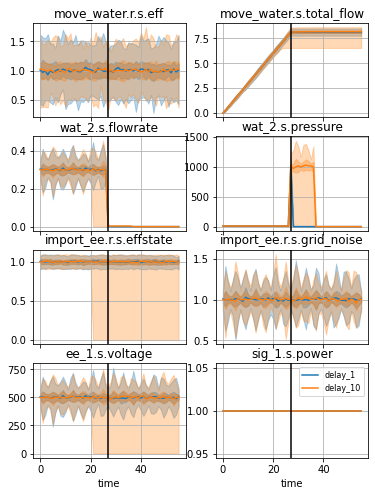

In [34]:
fig = an.plot.hist(comp_mdlhists,'move_water.r.s.eff', 'move_water.s.total_flow',
                   'wat_2.s.flowrate', 'wat_2.s.pressure',
                   'import_ee.r.s.effstate', 'import_ee.r.s.grid_noise',
                   'ee_1.s.voltage', 'sig_1.s.power', 
                    comp_groups=comp_groups, aggregation='percentile', time_slice=27) 

There a few interesting aspects of this simulation:
    - First, some of the `delay_1` design simulations have a zero flowrate before the fault is injected. This is because the reduced delay means that nominal behavior can easily cause the fault--all that nees to happen is for the pressure to go over 15 for two time-steps, which is entirely forseeable with all the variability in the simulation. This can also be seen in the "total_flow" graph.
    - Second, the `delay_10` gives the nominal behavior until the fault time, when pressure increases dramatically. This is also observed in the `delay_1` design, but with a much smaller delay (1 instead of 1).

Finally, running multiple simulations relies on the NominalApproach, it can be combined fairly easily with existing methods used in conjunction with NominalApproach. (e.g., `tabulate.nested_stats`).

In [35]:
an.tabulate.nested_stats(app_comp, endclasses, average_metrics=['cost'], inputparams=['delay'])

,delay_1_1.export_water_block_t2p0.endclass.rate,delay_1_1.export_water_block_t2p0.endclass.cost,delay_1_1.export_water_block_t2p0.endclass.expected cost,delay_1_1.export_water_block_t27p0.endclass.rate,delay_1_1.export_water_block_t27p0.endclass.cost,delay_1_1.export_water_block_t27p0.endclass.expected cost,delay_1_1.export_water_block_t52p0.endclass.rate,delay_1_1.export_water_block_t52p0.endclass.cost,delay_1_1.export_water_block_t52p0.endclass.expected cost,delay_1_1.nominal.endclass.rate,...,delay_10_200.export_water_block_t2p0.endclass.expected cost,delay_10_200.export_water_block_t27p0.endclass.rate,delay_10_200.export_water_block_t27p0.endclass.cost,delay_10_200.export_water_block_t27p0.endclass.expected cost,delay_10_200.export_water_block_t52p0.endclass.rate,delay_10_200.export_water_block_t52p0.endclass.cost,delay_10_200.export_water_block_t52p0.endclass.expected cost,delay_10_200.nominal.endclass.rate,delay_10_200.nominal.endclass.cost,delay_10_200.nominal.endclass.expected cost
delay,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000
ave_cost,40868.569567,40868.569567,40868.569567,40868.569567,40868.569567,40868.569567,40868.569567,40868.569567,40868.569567,40868.569567,...,39675.85272,39675.85272,39675.85272,39675.85272,39675.85272,39675.85272,39675.85272,39675.85272,39675.85272,39675.85272


In [36]:
an.tabulate.nested_factor_comparison(app_comp, endclasses, ['delay'], 'cost',  difference=False, percent=False)

"(delay,)",nominal,export_water
delay_1,50.0,16484.806610
delay_10,100.0,14853.623127
